In [5]:
# Como instalar pra usar GPU:
# https://www.tensorflow.org/install/pip
#!conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0 # usei e funcionou
#!pip install --upgrade pip
#!pip install "tensorflow<2.11"
#!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binaryornot                   0.4.4
bi


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import datetime as dt
import wget
import os
import pandas as pd
import numpy as np
from zipfile import ZipFile
from timeit import default_timer as timer
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from keras.utils import load_img
from keras.utils import save_img
from keras.utils import img_to_array
from keras.utils import array_to_img
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import SGD
import funcoes as f
import asyncio
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import plotly.express as px
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from joblib import dump, load
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import absl.logging
from tqdm.auto import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel('WARNING')
#tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# define o ticker do ativo que vou usar pra treinar o modelo
ticker = "BTCUSDT"
# timeframes precisa estar em ordem crescente e começar em 1s ou 1m
timeframes = ("1m", "5m", "15m", "30m", "1h")#, "2h", "4h", "8h", "1d")
# quantos períodos vamos olhar pro passado
lookback = 20
# numero de quantis pra usar no markov transition field. Precisa tunar.
quantis = 3
# pega número de timeframes por minuto ou segundo
timeframes_padronizado = tuple(f.timeframes_mesma_unidade(timeframes))
# tamanho das batches de treinamento
batch_size = 1024#512
# set seed pros resultados não variarem
seed = np.random.randint(99999)
seed = 777
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)
# pega tamanho da imagem (input)
img_shape = f.image_shape()
# porcentagem dos dados que vou usar pra treino e teste
pct_imagens_teste = 0.1
# numero de modelos pro ensemble
n_modelos=5
# proporção pra diminuir as imagens no momento da criação 1 é imagem inteira
img_size = 1.0
# investimento inicial em dolares
investimento_inicial = 1000
# fee em %
fee = 0.1

# Prepara os dados

### Baixa e corrige dados

In [ ]:
# baixa os dados e junta cada timeframe e junta em 1 csv por timeframe
# retorna None se arquivo processado já existe e timeframe se ele criou um arquivo do 0
lista_processados = []
for timeframe in timeframes:
    lista_processados.append(f.baixa_e_concatena(ticker= ticker, timeframe=timeframe, ano_inicial=2017))

In [ ]:
# insere linhas sem dados e preenche com 0
# só corrige os timeframes que foram processados anteriormente
lista_p_correcao = [item for item in lista_processados if item != None]
f.corrige_arquivos(lista_p_correcao)

### Cria janelas, GAF's e salva imagens
Imagens ficam localizadas na pasta dados e são separadas por clissificação de compra ou venda

In [3]:
# cria uma lista de numpy arrays com os dados de cada timeframe.
# Eles estão organizados na mesma ordem que os timeframes
dfs_close = [(pd.read_csv(f"./Dados/Processados/BTCUSDT-{timeframe}.csv", 
                      usecols=["Close time", "Close"])[::-1][["Close", "Close time"]]).to_numpy() for timeframe in timeframes]
dfs_close = tuple(dfs_close)

# faz a mesma coisa pros dados de volume
dfs_volume = [(pd.read_csv(f"./Dados/Processados/BTCUSDT-{timeframe}.csv", 
                      usecols=["Close time", "Volume"])[::-1][["Volume", "Close time"]]).to_numpy() for timeframe in timeframes]
dfs_volume = tuple(dfs_volume)

#dfs_close[0], dfs_volume[0]

In [10]:
# pra poder rodar asincrono precisa ter isso no topo da celula
#import nest_asyncio
#nest_asyncio.apply()

if __name__ == '__main__':
    ultima_linha = len(dfs_close[0])-(lookback*timeframes_padronizado[-1])
    print("qtd de imagens para treino", ultima_linha-int(ultima_linha*pct_imagens_teste))
    print("qtd de imagens para teste", int(ultima_linha*pct_imagens_teste))
    # linhas de teste são as primeiras x%, pois os dados mais recentes vem antes
    # linhas de treino são as restantes
    linhas_teste = range(0, int(ultima_linha*pct_imagens_teste))
    linhas_treino = range(int(ultima_linha*pct_imagens_teste)+1, ultima_linha+1)
    
    for linha in tqdm(linhas_teste):
        f.gera_imagem2(linha, dfs_close, dfs_volume, lookback, quantis, "teste", img_size)
    for linha in tqdm(linhas_treino):
        f.gera_imagem2(linha, dfs_close, dfs_volume, lookback, quantis, "treino", img_size)
    
    # multithreading está quebrado!
    # cria imagens usando multithreading
    #f.roda_async2(linhas_treino, linhas_teste, dfs_close, dfs_volume, lookback, quantis)
    # testar sem escalar as imagens no untitled.ipynb antes

qtd de imagens para treino 2542752
qtd de imagens para teste 282528


  0%|          | 0/282528 [00:00<?, ?it/s]

  0%|          | 0/2542752 [00:00<?, ?it/s]

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
E:\anaconda\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller fo

# Modelos

In [3]:
def CNN_hinge(img_shape=img_shape):
    # define our MLP network
    model = keras.Sequential()
    model.add(layers.Input(shape=img_shape))
    
    # reescala os dados pra entre 0 e 1
    model.add(layers.Rescaling(1./255))
    
    # primeira convolucao
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(1, 2)))
    model.add(layers.Dropout(0.15))
    
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(8, activation="relu"))
    model.add(layers.Dense(1, kernel_regularizer=l2(0.01)))
    model.add(layers.Activation('linear'))
    
    opt = Adam()
    model.compile(loss = "categorical_hinge", optimizer=opt, metrics=["accuracy",
                                                                     keras.metrics.Precision(),
                                                                     keras.metrics.Recall(), 
                                                                     keras.metrics.AUC()])
    return model

In [4]:
# rede CNN
def CNN(img_shape=img_shape):
    model = keras.Sequential()
    model.add(layers.Input(shape=img_shape))
    
    # reescala os dados pra entre 0 e 1
    model.add(layers.Rescaling(1./255))
    
    # convolucao
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(1, 2)))
    model.add(layers.Dropout(0.15))
    
    # classificação
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(8, activation="linear"))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    opt = Adagrad(learning_rate=0.1)
    model.compile(loss = "binary_crossentropy", optimizer=opt, metrics=["accuracy",
                                                                     keras.metrics.Precision(),
                                                                     keras.metrics.Recall(), 
                                                                     keras.metrics.AUC()])

    return model

In [16]:
# CNN VGG como no artigo
def CNN_VGG(img_shape=img_shape):
    model = keras.Sequential()
    #model.add(layers.Input(shape=(20, 180, 3)))
    model.add(layers.Input(shape=img_shape))
    
    # reescala os dados pra entre 0 e 1
    model.add(layers.Rescaling(1./255))
    
    # primeira convolucao
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    
    # segunda convolucao
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    
    # terceira
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    # FC_1024
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(1024, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    #opt = Adagrad(learning_rate=0.1)
    opt = Adam(learning_rate=0.0001)
    model.compile(loss = "binary_crossentropy", optimizer=opt, metrics=["accuracy",
                                                                     keras.metrics.Precision(),
                                                                     keras.metrics.Recall(), 
                                                                     keras.metrics.AUC()])

    return model

In [3]:
# CNN VGG como no artigo
def CNN_VGG(img_shape=img_shape):
    model = keras.Sequential()
    #model.add(layers.Input(shape=(20, 180, 3)))
    model.add(layers.Input(shape=img_shape))
    
    # reescala os dados pra entre 0 e 1
    model.add(layers.Rescaling(1./255))
    
    # primeira convolucao
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.15))
    
    # segunda convolucao
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.15))
    
    # terceira
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    # FC_1024
    model.add(layers.Flatten(name="flatten"))
    model.add(layers.Dense(1024, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))
    
    opt = Adam(learning_rate=0.0001)
    model.compile(loss = "binary_crossentropy", optimizer=opt, metrics=["accuracy",
                                                                     keras.metrics.Precision(),
                                                                     keras.metrics.Recall(), 
                                                                     keras.metrics.AUC()])

    return model

# Treino

Pega dados

In [4]:
train_data, validation_data = image_dataset_from_directory("./Dados/Imagens/treino/",
                                                   label_mode="binary",
                                                  image_size=img_shape[:2],
                                                  batch_size=batch_size,
                                                  subset="both",
                                                  validation_split=0.1,
                                                  seed=seed)

Found 2410498 files belonging to 2 classes.
Using 2169449 files for training.
Using 241049 files for validation.


### Treina CNN_hinge

In [6]:
modelos = [CNN_hinge() for i in range(n_modelos)]
resultado_CNN_hinge = np.empty((n_modelos, 5))
i = 0
for model in modelos:
    print("Modelo:", i)
    checkpoint = ModelCheckpoint(f"./modelos/modelo {i}", monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
    es = EarlyStopping(monitor='val_accuracy', patience=4, mode="max")
    callbacks_list = [checkpoint, es]

    # treina CNN hinge
    model.fit(train_data,  epochs=10, use_multiprocessing=True, callbacks=callbacks_list, validation_data=validation_data) #verbose=0
    model = keras.models.load_model(f"./modelos/modelo {i}")
    resultado_CNN_hinge[i] = model.evaluate(validation_data)
    i = i + 1

Modelo: 0
Epoch 1/10
2119/2119 [==============================] - 319s 144ms/step - loss: 0.9920 - accuracy: 0.5094 - precision: 0.5176 - recall: 0.2569 - auc: 0.5133 - val_loss: 0.9765 - val_accuracy: 0.5180 - val_precision: 0.5218 - val_recall: 0.3958 - val_auc: 0.5234
Epoch 2/10
2119/2119 [==============================] - 311s 146ms/step - loss: 0.9707 - accuracy: 0.5184 - precision: 0.5251 - recall: 0.3695 - auc: 0.5240 - val_loss: 0.9716 - val_accuracy: 0.5202 - val_precision: 0.5215 - val_recall: 0.4538 - val_auc: 0.5256
Epoch 3/10
2119/2119 [==============================] - 313s 147ms/step - loss: 0.9622 - accuracy: 0.5224 - precision: 0.5275 - recall: 0.4161 - auc: 0.5286 - val_loss: 0.9667 - val_accuracy: 0.5194 - val_precision: 0.5258 - val_recall: 0.3653 - val_auc: 0.5234
Epoch 4/10
2119/2119 [==============================] - 313s 147ms/step - loss: 0.9552 - accuracy: 0.5255 - precision: 0.5298 - recall: 0.4411 - auc: 0.5324 - val_loss: 0.9653 - val_accuracy: 0.5199 - val

### Treina CNN

In [7]:
modelos = [CNN() for i in range(n_modelos)]
resultado_CNN = np.empty((n_modelos, 5))
i = 0
for model in modelos:
    print("Modelo:", i)
    # precisa definir o checkpoint antes de começar cada CNN. Se não acaba usando um do outro
    checkpoint = ModelCheckpoint(f"./modelos/modelo CNN {i}", monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
    # para de treinar se a acuracia de treino parar de aumentar por 3 epochs
    es = EarlyStopping(monitor='val_accuracy', patience=4, mode="max")
    callbacks_list = [checkpoint, es]

    # treina CNN hinge
    model.fit(train_data,  epochs=10, use_multiprocessing=True, callbacks=callbacks_list, validation_data=validation_data) #verbose=0
    model = keras.models.load_model(f"./modelos/modelo CNN {i}")
    resultado_CNN[i] = model.evaluate(validation_data)
    i = i + 1

Modelo: 0
Epoch 1/10
2119/2119 [==============================] - 372s 175ms/step - loss: 0.6940 - accuracy: 0.5089 - precision_5: 0.5104 - recall_5: 0.4007 - auc_5: 0.5123 - val_loss: 0.6925 - val_accuracy: 0.5164 - val_precision_5: 0.5201 - val_recall_5: 0.3857 - val_auc_5: 0.5211
Epoch 2/10
2119/2119 [==============================] - 369s 173ms/step - loss: 0.6922 - accuracy: 0.5171 - precision_5: 0.5194 - recall_5: 0.4383 - auc_5: 0.5244 - val_loss: 0.6918 - val_accuracy: 0.5196 - val_precision_5: 0.5223 - val_recall_5: 0.4236 - val_auc_5: 0.5291
Epoch 3/10
2119/2119 [==============================] - 373s 175ms/step - loss: 0.6915 - accuracy: 0.5215 - precision_5: 0.5236 - recall_5: 0.4622 - auc_5: 0.5315 - val_loss: 0.6913 - val_accuracy: 0.5213 - val_precision_5: 0.5177 - val_recall_5: 0.5778 - val_auc_5: 0.5330
Epoch 4/10
2119/2119 [==============================] - 403s 189ms/step - loss: 0.6908 - accuracy: 0.5252 - precision_5: 0.5260 - recall_5: 0.4960 - auc_5: 0.5373 - val

Epoch 10/10
236/236 [==============================] - 30s 128ms/step - loss: 0.6909 - accuracy: 0.5247 - precision_7: 0.5242 - recall_7: 0.5022 - auc_7: 0.5350
Modelo: 3
Epoch 1/10
2119/2119 [==============================] - 379s 178ms/step - loss: 0.6930 - accuracy: 0.5070 - precision_8: 0.5064 - recall_8: 0.5036 - auc_8: 0.5098 - val_loss: 0.6927 - val_accuracy: 0.5120 - val_precision_8: 0.5082 - val_recall_8: 0.6525 - val_auc_8: 0.5178
Epoch 2/10
2119/2119 [==============================] - 378s 178ms/step - loss: 0.6924 - accuracy: 0.5147 - precision_8: 0.5135 - recall_8: 0.5309 - auc_8: 0.5208 - val_loss: 0.6922 - val_accuracy: 0.5187 - val_precision_8: 0.5153 - val_recall_8: 0.5821 - val_auc_8: 0.5254
Epoch 3/10
2119/2119 [==============================] - 376s 177ms/step - loss: 0.6917 - accuracy: 0.5214 - precision_8: 0.5196 - recall_8: 0.5512 - auc_8: 0.5297 - val_loss: 0.6923 - val_accuracy: 0.5183 - val_precision_8: 0.5113 - val_recall_8: 0.7626 - val_auc_8: 0.5281
Epoch 4

### Treina CNN Aproximada artigo

In [ ]:
resultado_CNN = np.empty((n_modelos, 5))
for i in range(n_modelos):
    print("Modelo:", i)
    model = CNN_VGG()
    # precisa definir o checkpoint antes de começar cada CNN. Se não acaba usando um do outro
    checkpoint = ModelCheckpoint(f"./modelos/modelo CNN VGG {i}", monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
    # para de treinar se a acuracia de treino parar de aumentar por 3 epochs
    es = EarlyStopping(monitor='val_accuracy', patience=4, mode="max")
    callbacks_list = [checkpoint, es]

    # treina CNN hinge
    model.fit(train_data,  epochs=50, use_multiprocessing=True, callbacks=callbacks_list, validation_data=validation_data) #verbose=0
    model = keras.models.load_model(f"./modelos/modelo CNN VGG {i}")
    resultado_CNN[i] = model.evaluate(validation_data)
    i = i + 1

Modelo: 0
Epoch 1/50
2119/2119 [==============================] - 307s 143ms/step - loss: 0.6931 - accuracy: 0.5040 - precision: 0.5035 - recall: 0.4507 - auc: 0.5053 - val_loss: 0.6929 - val_accuracy: 0.5087 - val_precision: 0.5117 - val_recall: 0.3554 - val_auc: 0.5122
Epoch 2/50
2119/2119 [==============================] - 324s 152ms/step - loss: 0.6929 - accuracy: 0.5081 - precision: 0.5076 - recall: 0.4915 - auc: 0.5111 - val_loss: 0.6928 - val_accuracy: 0.5095 - val_precision: 0.5118 - val_recall: 0.3914 - val_auc: 0.5146
Epoch 3/50
2119/2119 [==============================] - 323s 152ms/step - loss: 0.6928 - accuracy: 0.5095 - precision: 0.5092 - recall: 0.4801 - auc: 0.5136 - val_loss: 0.6927 - val_accuracy: 0.5101 - val_precision: 0.5129 - val_recall: 0.3794 - val_auc: 0.5170
Epoch 4/50
2119/2119 [==============================] - 335s 157ms/step - loss: 0.6927 - accuracy: 0.5106 - precision: 0.5101 - recall: 0.4949 - auc: 0.5156 - val_loss: 0.6925 - val_accuracy: 0.5117 - val

2119/2119 [==============================] - 364s 171ms/step - loss: 0.6920 - accuracy: 0.5180 - precision_1: 0.5172 - recall_1: 0.5166 - auc_1: 0.5261 - val_loss: 0.6919 - val_accuracy: 0.5169 - val_precision_1: 0.5176 - val_recall_1: 0.4819 - val_auc_1: 0.5271
Epoch 9/50
2119/2119 [==============================] - 367s 173ms/step - loss: 0.6918 - accuracy: 0.5197 - precision_1: 0.5190 - recall_1: 0.5152 - auc_1: 0.5284 - val_loss: 0.6918 - val_accuracy: 0.5198 - val_precision_1: 0.5218 - val_recall_1: 0.4641 - val_auc_1: 0.5289
Epoch 10/50
2119/2119 [==============================] - 367s 172ms/step - loss: 0.6916 - accuracy: 0.5210 - precision_1: 0.5204 - recall_1: 0.5151 - auc_1: 0.5308 - val_loss: 0.6917 - val_accuracy: 0.5202 - val_precision_1: 0.5225 - val_recall_1: 0.4563 - val_auc_1: 0.5300
Epoch 11/50
2119/2119 [==============================] - 367s 173ms/step - loss: 0.6914 - accuracy: 0.5224 - precision_1: 0.5220 - recall_1: 0.5125 - auc_1: 0.5326 - val_loss: 0.6916 - val

2119/2119 [==============================] - 392s 184ms/step - loss: 0.6899 - accuracy: 0.5297 - precision_2: 0.5292 - recall_2: 0.5245 - auc_2: 0.5435 - val_loss: 0.6910 - val_accuracy: 0.5241 - val_precision_2: 0.5263 - val_recall_2: 0.4719 - val_auc_2: 0.5353
Epoch 17/50
2119/2119 [==============================] - 396s 186ms/step - loss: 0.6896 - accuracy: 0.5317 - precision_2: 0.5312 - recall_2: 0.5265 - auc_2: 0.5458 - val_loss: 0.6912 - val_accuracy: 0.5244 - val_precision_2: 0.5244 - val_recall_2: 0.5142 - val_auc_2: 0.5354
Epoch 18/50
 312/2119 [===>..........................] - ETA: 5:06 - loss: 0.6893 - accuracy: 0.5330 - precision_2: 0.5327 - recall_2: 0.5314 - auc_2: 0.5481

# Teste

Pega dados de teste

In [9]:
test_data = image_dataset_from_directory("./Dados/Imagens/teste/",
                                                   label_mode="binary",
                                                 image_size=img_shape[:2],
                                                  batch_size=batch_size,
                                                 shuffle=False,
                                                  seed=seed)

Found 282291 files belonging to 2 classes.


### Testa modelos CNN_hinge individualmente

In [9]:
# mostra o resultado pra cada um dos modelos treinados
resultado_CNN_hinge = np.empty((n_modelos, 5))
i = 0
for i in range(n_modelos):
    model = keras.models.load_model(f"./modelos/modelo {i}")
    print(f"modelo {i}")
    resultado_CNN_hinge[i] = model.evaluate(test_data)
# transforma resultados CNN em df e tira a loss
resultado_CNN_hinge = pd.DataFrame(resultado_CNN_hinge, columns=["loss", "accuracy", "precision", "recall", "AUC"]).drop(columns=["loss"])
# calcula f1
resultado_CNN_hinge["f1-score"] = 2*(resultado_CNN_hinge["precision"]*resultado_CNN_hinge["recall"])/(resultado_CNN_hinge["precision"]+resultado_CNN_hinge["recall"])
# poe 0 nos nans
resultado_CNN_hinge.fillna(0, inplace=True)
# reordena as colunas
colunas = ["accuracy", "precision", "recall", "f1-score", "AUC"]
resultado_CNN_hinge = resultado_CNN_hinge[colunas]
display(resultado_CNN_hinge)

modelo 0
276/276 [==============================] - 41s 146ms/step - loss: 0.9704 - accuracy: 0.5204 - precision: 0.5236 - recall: 0.4532 - auc: 0.5250
modelo 1
276/276 [==============================] - 34s 123ms/step - loss: 0.9682 - accuracy: 0.5190 - precision_1: 0.5247 - recall_1: 0.4036 - auc_1: 0.5230
modelo 2
276/276 [==============================] - 35s 125ms/step - loss: 1.0001 - accuracy: 0.5000 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_2: 0.5000
modelo 3
276/276 [==============================] - 35s 125ms/step - loss: 0.9636 - accuracy: 0.5214 - precision_3: 0.5264 - recall_3: 0.4261 - auc_3: 0.5243
modelo 4
276/276 [==============================] - 35s 124ms/step - loss: 0.9703 - accuracy: 0.5194 - precision_4: 0.5209 - recall_4: 0.4838 - auc_4: 0.5213


,accuracy,precision,recall,f1-score,AUC
0,0.520389,0.523571,0.453152,0.485823,0.525021
1,0.518989,0.524703,0.403588,0.456244,0.523031
2,0.499988,0.000000,0.000000,0.000000,0.500000
3,0.521398,0.526449,0.426145,0.471017,0.524324
4,0.519375,0.520872,0.483815,0.501660,0.521282


### Testa modelos CNN individualmente

In [17]:
# mostra o resultado pra cada um dos modelos treinados
resultado_CNN = np.empty((n_modelos, 5))
i = 0
for i in range(n_modelos):
    model = keras.models.load_model(f"./modelos/modelo CNN {i}")
    print(f"modelo CNN {i}")
    resultado_CNN[i] = model.evaluate(test_data)
# transforma resultados CNN em df e tira a loss
resultado_CNN = pd.DataFrame(resultado_CNN, columns=["loss", "accuracy", "precision", "recall", "AUC"]).drop(columns=["loss"])
# calcula f1
resultado_CNN["f1-score"] = 2*(resultado_CNN["precision"]*resultado_CNN["recall"])/(resultado_CNN["precision"]+resultado_CNN["recall"])
# poe 0 nos nans
resultado_CNN.fillna(0, inplace=True)
# reordena as colunas
colunas = ["accuracy", "precision", "recall", "f1-score", "AUC"]
resultado_CNN = resultado_CNN[colunas]
display(resultado_CNN)

modelo CNN 0
276/276 [==============================] - 44s 159ms/step - loss: 0.6930 - accuracy: 0.5161 - precision_5: 0.5176 - recall_5: 0.4740 - auc_5: 0.5233
modelo CNN 1
276/276 [==============================] - 41s 148ms/step - loss: 0.6937 - accuracy: 0.5142 - precision_6: 0.5162 - recall_6: 0.4507 - auc_6: 0.5201
modelo CNN 2
276/276 [==============================] - 43s 154ms/step - loss: 0.6927 - accuracy: 0.5162 - precision_7: 0.5175 - recall_7: 0.4796 - auc_7: 0.5224
modelo CNN 3
276/276 [==============================] - 41s 148ms/step - loss: 0.6932 - accuracy: 0.5182 - precision_8: 0.5212 - recall_8: 0.4474 - auc_8: 0.5244
modelo CNN 4
276/276 [==============================] - 41s 147ms/step - loss: 0.6941 - accuracy: 0.5124 - precision_9: 0.5126 - recall_9: 0.5078 - auc_9: 0.5189


,accuracy,precision,recall,f1-score,AUC
0,0.516148,0.517647,0.474045,0.494887,0.523343
1,0.514154,0.516224,0.450744,0.481267,0.520120
2,0.516219,0.517515,0.479571,0.497821,0.522369
3,0.518217,0.521237,0.447407,0.481508,0.524353
4,0.512436,0.512565,0.507804,0.510173,0.518860


### Testa modelos CNN VGG individualmente

In [10]:
# mostra o resultado pra cada um dos modelos treinados
resultado_CNN = np.empty((n_modelos, 5))
i = 0
for i in range(n_modelos):
    model = keras.models.load_model(f"./modelos/modelo CNN VGG {i}")
    print(f"modelo CNN VGG {i}")
    resultado_CNN[i] = model.evaluate(test_data)
# transforma resultados CNN em df e tira a loss
resultado_CNN = pd.DataFrame(resultado_CNN, columns=["loss", "accuracy", "precision", "recall", "AUC"]).drop(columns=["loss"])
# calcula f1
resultado_CNN["f1-score"] = 2*(resultado_CNN["precision"]*resultado_CNN["recall"])/(resultado_CNN["precision"]+resultado_CNN["recall"])
# poe 0 nos nans
resultado_CNN.fillna(0, inplace=True)
# reordena as colunas
colunas = ["accuracy", "precision", "recall", "f1-score", "AUC"]
resultado_CNN = resultado_CNN[colunas]
display(resultado_CNN)

modelo CNN VGG 0
276/276 [==============================] - 40s 144ms/step - loss: 0.6926 - accuracy: 0.5163 - precision: 0.5190 - recall: 0.4468 - auc: 0.5254


,accuracy,precision,recall,f1-score,AUC
0,5.163218e-01,5.189701e-01,4.468470e-01,0.480216,5.254138e-01
1,6.952549e-310,6.952549e-310,6.952549e-310,0.000000,6.952549e-310
2,6.952549e-310,6.952549e-310,6.952549e-310,0.000000,6.952549e-310
3,6.952549e-310,6.952549e-310,6.952549e-310,0.000000,6.952549e-310
4,6.952549e-310,6.952549e-310,6.952549e-310,0.000000,6.952549e-310


## Teste Ensemble

In [19]:
def decisao(x, threshold):
    '''
    Transforma valores em 1, -1 ou 0 com base no valor do threshold.
    
    x: valor entre -1 e 1 que iremos transformar em -1, 0 ou 1
    
    threshold: valor entre 0.5 e 1 que irá definir a % de certeza 
    para que x seja classificado entre -1 (long), 1 (short) ou 0 (nada)
    '''
    threshold = (threshold*2)-1
    if (x >= threshold):
        x = 1
    elif (x <= (0-threshold)):
        x = -1
    else:
        x = 0
    return x

In [20]:
def calcula_resultado(y_pred_ensemble, investimento_inicial=investimento_inicial, fee=fee, timeframe=timeframes[0]):
    """
    Retorna tupla com lucro em dolares para a estratégia com e sem fee.
    
    params:
    y_pred_ensemble: dataframe com "y_pred" na primeira coluna. Precisa estar na mesma ordem que y_true
    
    investimento_inicial: valor em dolares a ser investido
    
    fee: valor em percentual do fee por trade
    
    """
    # junta os nomes dos arquivos com y_true e y_pred. Estão na mesma ordem
    df = pd.concat([pd.DataFrame(test_data.file_paths, columns=["path"]), y_pred_ensemble], axis=1)
    df[["path", "Close time"]] = df["path"].str.split("\\", expand=True)
    df["Close time"] = df["Close time"].str.split(".", expand=True).iloc[:, 0].astype("int64")
    df["path"] = df["path"].str.split("/").str[-1]
    df.sort_values(by="Close time", inplace=True)

    # da join com os dados de preço usando close time como chave
    df = pd.merge(df,
            pd.read_csv(f"./Dados/Processados/BTCUSDT-{timeframe}.csv")[::-1][["Close time", "Close"]],
             how="left", 
             on="Close time")
    df["Close time"] = pd.to_datetime(df["Close time"], unit="ms")
    
    df["dif"] = (df["Close"] - df["Close"].shift(1))
    df["dif short"] = (-df["Close"] - (-df["Close"].shift(1)))

    df.loc[df["y_pred"].shift(1) == -1, "dif trade"] = df.loc[df["y_pred"].shift(1) == -1, "dif"]
    df.loc[df["y_pred"].shift(1) == 1, "dif trade"] = df.loc[df["y_pred"].shift(1) == 1, "dif short"]
    df.loc[df["y_pred"].shift(1) == 0, "dif trade"] = 0

    # tira taxa de compra e venda (0,1% cada operação de compra/venda)
    df.loc[:, "dif trade com fee"] = df["dif trade"] - df["Close"]*(fee/100)*2

    df.fillna(0, inplace=True)
    df["PnL long"] = df["dif"].cumsum()
    df["PnL short"] = df["dif short"].cumsum()
    df["PnL trade"] = df["dif trade"].cumsum()
    df["PnL trade com fee"] = df["dif trade com fee"].cumsum()

    df["Retorno long acum"] = df["PnL long"]/df.at[0, "Close"] 
    df["Retorno short acum"] = df["PnL short"]/df.at[0, "Close"]
    df["Retorno trade acum"] = df["PnL trade"]/df.at[0, "Close"]
    df["Retorno trade com fee acum"] = df["PnL trade com fee"]/df.at[0, "Close"]

    df["Investimento long only"] = investimento_inicial*df["Retorno long acum"] + investimento_inicial
    df["Investimento short only"] = investimento_inicial*df["Retorno short acum"] + investimento_inicial
    df["Investimento trade"] = investimento_inicial*df["Retorno trade acum"] + investimento_inicial
    df["Investimento trade com fee"] = investimento_inicial*df["Retorno trade com fee acum"] + investimento_inicial


    # joga fora outras colunas
    cols = ["Close time", "Investimento long only", "Investimento short only", "Investimento trade", "Investimento trade com fee"]
    df = df[cols].copy()
    df.set_index("Close time", inplace=True) 
    # se tiver valor = 0 vira 0
    df.loc[df["Investimento trade com fee"]<0, "Investimento trade com fee"] = 0

    resultado = (df["Investimento trade"].iat[-1]).round(2) - investimento_inicial
    resultado_fee = (df["Investimento trade com fee"].iat[-1]).round(2) - investimento_inicial
    resultado_comprado = (df["Investimento long only"].iat[-1]).round(2) - investimento_inicial
    resultado_vendido = (df["Investimento short only"].iat[-1]).round(2) - investimento_inicial
    # dá pra plotar resultado se quiser
    #df.plot()
    
    return resultado, resultado_fee, resultado_comprado, resultado_vendido

In [21]:
def calcula_metricas(y_true, y_pred, threshold, investimento_inicial=investimento_inicial, fee=fee):
    '''
    Calcula metricas com base em um threshold específico.
    Métricas: accuracy, precision, recall, f1-score, AUC
    '''
    y_pred_ensemble = y_pred.applymap(lambda x: decisao(x, threshold))
    # calcula a moda por linha para definir qual o consenso do modelo
    y_pred_ensemble = y_pred_ensemble.mode(axis=1)
    # se tem 2 modas ou mais, classificação deve ser 0 (não fazer nada)
    if len(y_pred_ensemble.columns) >= 2:
        y_pred_ensemble.loc[y_pred_ensemble.iloc[:, 1].notna(), y_pred_ensemble.columns[0]] = 0
        y_pred_ensemble.drop(columns=y_pred_ensemble.columns[1], inplace=True)
    y_pred_ensemble.columns = ["y_pred"]
    
    # coloca y_true ao lado de y_pred
    y_pred_ensemble["y_true"] = y_true
    # converte dtypes pra int
    y_pred_ensemble = y_pred_ensemble.astype(int)
    
    resultado, resultado_fee, resultado_comprado, resultado_vendido = calcula_resultado(y_pred_ensemble, investimento_inicial, fee)
    
    # joga fora linhas onde y_pred é 0, pois não iremos operar nestes casos
    y_pred_ensemble.drop(y_pred_ensemble[y_pred_ensemble["y_pred"] == 0].index, inplace=True)
    # converte as linhas que são -1 em 0, pra poder comparar com y_true
    y_pred_ensemble.loc[y_pred_ensemble["y_pred"] == -1, "y_pred"] = 0
    
    # calcular metricas pro ensemble
    y_true_ensemble = y_pred_ensemble["y_true"].to_numpy().ravel()
    y_pred_ensemble = y_pred_ensemble["y_pred"].to_numpy().ravel()

    # pega o numero de operações totais pra calcular quantos % restam depois (indice de cobertura)
    n_operacoes_total = len(y_true)
    n_operacoes = len(y_pred_ensemble)
    cobertura = n_operacoes/n_operacoes_total
    
    if n_operacoes > 1:
        metricas = np.array([accuracy_score(y_true_ensemble, y_pred_ensemble),
                       precision_score(y_true_ensemble, y_pred_ensemble), 
                       recall_score(y_true_ensemble, y_pred_ensemble), 
                       f1_score(y_true_ensemble, y_pred_ensemble),
                       roc_auc_score(y_true_ensemble, y_pred_ensemble)
                      ])
        metricas = pd.DataFrame(metricas.reshape((1, 5)), columns=["accuracy", "precision", "recall", "f1-score", "AUC"])
    else:
        metricas = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1-score", "AUC"])
    
    metricas["% cobertura"] = cobertura
    metricas["threshold"] = threshold
    metricas["Resultado"] = resultado
    metricas["Resultado com fees"] = resultado_fee
    metricas["Resultado apenas comprado"] = resultado_comprado
    metricas["Resultado apenas vendido"] = resultado_vendido
    
    
    return metricas

In [7]:
# pega labels reais do teste
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

## Teste ensemble CNN_hinge

In [22]:
# pega predições CNN hinge
y_pred = pd.DataFrame()
i = 0
for i in range(n_modelos):
    model = keras.models.load_model(f"./modelos/modelo {i}")
    print(f"modelo {i}")
    y_pred[f"modelo {i}"] = model.predict(test_data).ravel().tolist()


modelo 0
276/276 [==============================] - 36s 130ms/step
modelo 1
276/276 [==============================] - 35s 126ms/step
modelo 2
276/276 [==============================] - 34s 122ms/step
modelo 3
276/276 [==============================] - 33s 121ms/step
modelo 4
276/276 [==============================] - 33s 119ms/step


In [23]:
# cria df onde iremos unir todas as metricas
metricas_CNN_hinge = pd.DataFrame()
thresholds = [0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95, 1]

# calcula metricas
for threshold in thresholds:
    print(f"Calculando para {threshold}")
    metricas_CNN_hinge = pd.concat([metricas_CNN_hinge, calcula_metricas(y_true, y_pred, threshold)], axis = 0)
metricas_CNN_hinge

Calculando para 0.5
Calculando para 0.55
Calculando para 0.6
Calculando para 0.7
Calculando para 0.8
Calculando para 0.9
Calculando para 0.95
Calculando para 1


,accuracy,precision,recall,f1-score,AUC,% cobertura,threshold,Resultado,Resultado com fees,Resultado apenas comprado,Resultado apenas vendido
0,0.521724,0.522479,0.505211,0.513700,0.521724,1.000000,0.50,735.31,-1000.0,-93.84,93.84
0,0.523547,0.523342,0.547879,0.535329,0.523501,0.882940,0.55,467.04,-1000.0,-93.84,93.84
0,0.524375,0.523656,0.551309,0.537127,0.524345,0.840675,0.60,446.40,-1000.0,-93.84,93.84
0,0.526317,0.525578,0.558071,0.541337,0.526260,0.755816,0.70,477.84,-1000.0,-93.84,93.84
0,0.528505,0.527820,0.566482,0.546468,0.528396,0.671261,0.80,319.11,-1000.0,-93.84,93.84
0,0.532981,0.529788,0.708818,0.606364,0.530314,0.461272,0.90,464.80,-1000.0,-93.84,93.84
0,0.534396,0.532257,0.875436,0.662015,0.519537,0.286368,0.95,585.68,-1000.0,-93.84,93.84
0,0.538889,0.538512,0.948850,0.687079,0.509433,0.074512,1.00,94.93,-1000.0,-93.84,93.84


## Teste ensemble CNN

In [24]:
# pega predições CNN
y_pred = pd.DataFrame()
i = 0
for i in range(n_modelos):
    model = keras.models.load_model(f"./modelos/modelo CNN {i}")
    print(f"modelo {i}")
    y_pred[f"modelo {i}"] = model.predict(test_data).ravel().tolist()
y_pred

# transforma y_pred em range entre -1 e 1. Pra fazer ficar entre 0 e 1 é y_pred = (y_pred+1)/2
y_pred = y_pred*2-1

modelo 0
276/276 [==============================] - 35s 127ms/step
modelo 1
276/276 [==============================] - 35s 127ms/step
modelo 2
276/276 [==============================] - 36s 129ms/step
modelo 3
276/276 [==============================] - 35s 127ms/step
modelo 4
276/276 [==============================] - 35s 127ms/step


In [25]:
# cria df onde iremos unir todas as metricas
metricas_CNN = pd.DataFrame()
thresholds = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.6]#, 0.7, 0.8, 0.9, 0.95, 1]

# calcula metricas
for threshold in thresholds:
    print(f"Calculando para {threshold}")
    metricas_CNN = pd.concat([metricas_CNN, calcula_metricas(y_true, y_pred, threshold)], axis = 0)
metricas_CNN

Calculando para 0.5
Calculando para 0.51
Calculando para 0.52
Calculando para 0.53
Calculando para 0.54
Calculando para 0.55
Calculando para 0.6


,accuracy,precision,recall,f1-score,AUC,% cobertura,threshold,Resultado,Resultado com fees,Resultado apenas comprado,Resultado apenas vendido
0,0.518437,0.520625,0.465678,0.491621,0.518438,1.000000,0.50,1760.92,-1000.0,-93.84,93.84
0,0.524174,0.527257,0.456504,0.489336,0.524092,0.705003,0.51,1461.65,-1000.0,-93.84,93.84
0,0.528615,0.531491,0.448609,0.486546,0.528273,0.472346,0.52,888.34,-1000.0,-93.84,93.84
0,0.533126,0.536169,0.436257,0.481081,0.532371,0.310711,0.53,344.29,-1000.0,-93.84,93.84
0,0.537009,0.539719,0.416553,0.470204,0.535400,0.204884,0.54,192.64,-1000.0,-93.84,93.84
0,0.540842,0.543251,0.352017,0.427210,0.535850,0.127067,0.55,52.78,-1000.0,-93.84,93.84
0,0.545384,0.537975,0.188784,0.279490,0.523346,0.013660,0.60,14.34,-1000.0,-93.84,93.84


# Confere rentabilidade

In [7]:
# pega predições CNN
y_pred = pd.DataFrame()
i = 0
for i in range(n_modelos):
    model = keras.models.load_model(f"./modelos/modelo CNN {i}")
    print(f"modelo {i}")
    y_pred[f"modelo {i}"] = model.predict(test_data).ravel().tolist()
y_pred

# transforma y_pred em range entre -1 e 1. Pra fazer ficar entre 0 e 1 é y_pred = (y_pred+1)/2
y_pred = y_pred*2-1

# pega labels reais do teste
y_true = np.concatenate([y for x, y in test_data], axis=0)
threshold = 0.5

# investimento inicial em dolares
investimento_inicial = 1000
# fee em %
fee = 0.1

modelo 0
276/276 [==============================] - 35s 122ms/step
modelo 1
276/276 [==============================] - 27s 97ms/step
modelo 2
276/276 [==============================] - 28s 100ms/step
modelo 3
276/276 [==============================] - 27s 97ms/step
modelo 4
276/276 [==============================] - 27s 98ms/step


In [8]:
# pra rodar isso precisa de y_pred, y_true e threshold
y_pred_ensemble = y_pred.applymap(lambda x: decisao(x, threshold))
# calcula a moda por linha para definir qual o consenso do modelo
y_pred_ensemble = y_pred_ensemble.mode(axis=1)
# se tem 2 modas ou mais, classificação deve ser 0 (não fazer nada)
if len(y_pred_ensemble.columns) >= 2:
    y_pred_ensemble.loc[y_pred_ensemble.iloc[:, 1].notna(), y_pred_ensemble.columns[0]] = 0
    y_pred_ensemble.drop(columns=y_pred_ensemble.columns[1], inplace=True)
y_pred_ensemble.columns = ["y_pred"]

# coloca y_true ao lado de y_pred
y_pred_ensemble["y_true"] = y_true
# converte dtypes pra int
y_pred_ensemble = y_pred_ensemble.astype(int)

y_pred_ensemble

,y_pred,y_true
0,-1,0
1,1,0
2,-1,0
3,1,0
4,-1,0
...,...,...
282286,1,1
282287,1,1
282288,1,1
282289,1,1


In [227]:
# junta os nomes dos arquivos com y_true e y_pred. Estão na mesma ordem
df = pd.concat([pd.DataFrame(test_data.file_paths, columns=["path"]), y_pred_ensemble], axis=1)
df[["path", "Close time"]] = df["path"].str.split("\\", expand=True)
df["Close time"] = df["Close time"].str.split(".", expand=True).iloc[:, 0].astype("int64")
df["path"] = df["path"].str.split("/").str[-1]
df.sort_values(by="Close time", inplace=True)

# da join com os dados de preço usando close time como chave
df = pd.merge(df,
        pd.read_csv("./Dados/Processados/BTCUSDT-1m.csv")[::-1][["Close time", "Close"]],
         how="left", 
         on="Close time")
df["Close time"] = pd.to_datetime(df["Close time"], unit="ms")

df

,path,y_pred,y_true,Close time,Close
0,short1,1,1,2022-06-18 19:12:59.999,18255.42
1,short1,1,1,2022-06-18 19:13:59.999,18238.64
2,long0,-1,0,2022-06-18 19:14:59.999,18223.01
3,long0,1,0,2022-06-18 19:15:59.999,18279.86
4,short1,1,1,2022-06-18 19:16:59.999,18304.24
...,...,...,...,...,...
282286,long0,1,0,2022-12-31 23:55:59.999,16539.28
282287,short1,1,1,2022-12-31 23:56:59.999,16540.52
282288,short1,1,1,2022-12-31 23:57:59.999,16537.78
282289,long0,1,0,2022-12-31 23:58:59.999,16536.42


In [228]:


df["dif"] = (df["Close"] - df["Close"].shift(1))
df["dif short"] = (-df["Close"] - (-df["Close"].shift(1)))

df.loc[df["y_pred"].shift(1) == -1, "dif trade"] = df.loc[df["y_pred"].shift(1) == -1, "dif"]
df.loc[df["y_pred"].shift(1) == 1, "dif trade"] = df.loc[df["y_pred"].shift(1) == 1, "dif short"]
df.loc[df["y_pred"].shift(1) == 0, "dif trade"] = 0

# tira taxa de compra e venda (0,1% cada operação de compra/venda)
df.loc[:, "dif trade com fee"] = df["dif trade"] - df["Close"]*(fee/100)*2

df.fillna(0, inplace=True)
df["PnL long"] = df["dif"].cumsum()
df["PnL short"] = df["dif short"].cumsum()
df["PnL trade"] = df["dif trade"].cumsum()
df["PnL trade com fee"] = df["dif trade com fee"].cumsum()

df["Retorno long acum"] = df["PnL long"]/df.at[0, "Close"] 
df["Retorno short acum"] = df["PnL short"]/df.at[0, "Close"]
df["Retorno trade acum"] = df["PnL trade"]/df.at[0, "Close"]
df["Retorno trade com fee acum"] = df["PnL trade com fee"]/df.at[0, "Close"]

df["Investimento long only"] = investimento_inicial*df["Retorno long acum"] + investimento_inicial
df["Investimento short only"] = investimento_inicial*df["Retorno short acum"] + investimento_inicial
df["Investimento trade"] = investimento_inicial*df["Retorno trade acum"] + investimento_inicial
df["Investimento trade com fee"] = investimento_inicial*df["Retorno trade com fee acum"] + investimento_inicial


# joga fora outras colunas
cols = ["Close time", "Investimento long only", "Investimento short only", "Investimento trade", "Investimento trade com fee"]
df = df[cols].copy()
df.set_index("Close time", inplace=True) 
# se tiver valor = 0 vira 0
df.loc[df["Investimento trade com fee"]<0, "Investimento trade com fee"] = 0

resultado = (df["Investimento trade"].iat[-1]).round(2)
resultado_fee = (df["Investimento trade com fee"].iat[-1]).round(2)
print(resultado)
df#.head(30)

2763.14


,Investimento long only,Investimento short only,Investimento trade,Investimento trade com fee
Close time,,,,
2022-06-18 19:12:59.999,1000.000000,1000.000000,1000.000000,1000.000000
2022-06-18 19:13:59.999,999.080821,1000.919179,1000.919179,998.921017
2022-06-18 19:14:59.999,998.224637,1001.775363,1001.775363,997.780752
2022-06-18 19:15:59.999,1001.338780,998.661220,1004.889507,998.892218
2022-06-18 19:16:59.999,1002.674274,997.325726,1003.554013,995.551376
...,...,...,...,...
2022-12-31 23:55:59.999,905.992850,1094.007150,2763.314128,0.000000
2022-12-31 23:56:59.999,906.060775,1093.939225,2763.246203,0.000000
2022-12-31 23:57:59.999,905.910683,1094.089317,2763.396295,0.000000


<Axes: xlabel='Close time'>

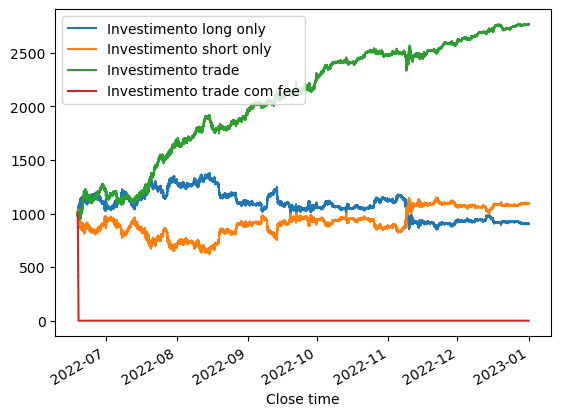

In [222]:

df.plot()# logy=True, ylim=(0,4000)
#df.drop(columns=["Investimento trade com fee"]).plot()

In [178]:
len(df[df["y_pred"] == df["y_true"]]) / len(df["y_true"])

0.5184437335940572

In [153]:
# retorno = rendimento/posicao do dia anterior
# rendimento é posicao de hoje - posicao de ontem
# posicao é qtd * preco
# da pra diminuir os custos do rendimento. custo de trade da binance é 0.1%

In [137]:
investimento_inicial = 1000
quantidade_inicial = investimento_inicial/df["Close"]
df["Posicao"] = 0
df.loc[0, "Posicao"] = investimento_inicial
df.loc[0, "Quantidade"] = df.at[0, "Posicao"]/df.at[0 ,"Close"]
df

,path,y_pred,y_true,Close time,Close,Posicao,Quantidade,Retorno
0,short1,1,1,2022-06-18 19:12:59.999,18255.42,1000,0.054778,NaN
1,short1,1,1,2022-06-18 19:13:59.999,18238.64,0,NaN,-0.000919
2,long0,-1,0,2022-06-18 19:14:59.999,18223.01,0,NaN,-0.000857
3,long0,1,0,2022-06-18 19:15:59.999,18279.86,0,NaN,0.003120
4,short1,1,1,2022-06-18 19:16:59.999,18304.24,0,NaN,0.001334
...,...,...,...,...,...,...,...,...
282286,long0,1,0,2022-12-31 23:55:59.999,16539.28,0,NaN,-0.000069
282287,short1,1,1,2022-12-31 23:56:59.999,16540.52,0,NaN,0.000075
282288,short1,1,1,2022-12-31 23:57:59.999,16537.78,0,NaN,-0.000166
282289,long0,1,0,2022-12-31 23:58:59.999,16536.42,0,NaN,-0.000082


In [149]:
#df["Rentabilidade B&H"] = (df["Close"].pct_change().fillna(0)+1)#.cumprod()-1
# calcula rentabilidade diaria pra trade
df["Rentabilidade Long"] = df["Close"].pct_change().fillna(0)
#df["Rentabilidade Short"] = (df["Close"].shift(1) / df["Close"])-1#.cumprod()
df["Rentabilidade Short"] = df["Rentabilidade Long"]*(-1)

df["Rentabilidade Trade"] = np.nan

"""# magia negra pra pegar a rentabilidade certa pra cada tipo de operação
df.loc[:, ["Rentabilidade Long", "Rentabilidade Short", "Rentabilidade Trade"]] = df[["Rentabilidade Long", "Rentabilidade Short", "Rentabilidade Trade"]].shift(-1, axis=0)

# quando y_pred é 0, não operamos e a rentabilidade é 0
df.loc[df["y_pred"] == 0, "Rentabilidade Trade"] = 0

# quando y_pred é 1, a rentabilidade diária é o da coluna short
df.loc[df["y_pred"] == 1, "Rentabilidade Trade"] = df.loc[df["y_pred"] == 1, "Rentabilidade Short"]

# quando y_pred é -1, a rentabilidade diária é o da coluna long
df.loc[df["y_pred"] == -1, "Rentabilidade Trade"] = df.loc[df["y_pred"] == -1, "Rentabilidade Long"]

# desfaz magia negra
df.loc[:, ["Rentabilidade Long", "Rentabilidade Short", "Rentabilidade Trade"]] = df[["Rentabilidade Long", "Rentabilidade Short", "Rentabilidade Trade"]].shift(1, axis=0)
"""
df.fillna(0, inplace=True)
# soma 1 e acumula
df["Rentabilidade Trade"] = (df["Rentabilidade Trade"]+1).cumprod()-1
df["Rentabilidade Short"] = (df["Rentabilidade Short"]+1).cumprod()-1
df["Rentabilidade Long"] = (df["Rentabilidade Long"]+1).cumprod()-1

df

,path,y_pred,y_true,Close time,Close,Rentabilidade Long,Rentabilidade Short,Rentabilidade Trade
0,short1,1,1,2022-06-18 19:12:59.999,18255.42,0.000000,0.000000,0.0
1,short1,1,1,2022-06-18 19:13:59.999,18238.64,-0.000919,0.000919,0.0
2,long0,-1,0,2022-06-18 19:14:59.999,18223.01,-0.001775,0.001777,0.0
3,long0,1,0,2022-06-18 19:15:59.999,18279.86,0.001339,-0.001348,0.0
4,short1,1,1,2022-06-18 19:16:59.999,18304.24,0.002674,-0.002680,0.0
...,...,...,...,...,...,...,...,...
282286,long0,1,0,2022-12-31 23:55:59.999,16539.28,-0.094007,-0.087369,0.0
282287,short1,1,1,2022-12-31 23:56:59.999,16540.52,-0.093939,-0.087438,0.0
282288,short1,1,1,2022-12-31 23:57:59.999,16537.78,-0.094089,-0.087286,0.0
282289,long0,1,0,2022-12-31 23:58:59.999,16536.42,-0.094164,-0.087211,0.0


In [25]:
df.at[1, "Rentabilidade Short"]

0.0009200247386866867

In [120]:
df.to_excel("teste.xlsx")

In [ ]:

# joga fora linhas onde y_pred é 0, pois não iremos operar nestes casos
y_pred_ensemble.drop(y_pred_ensemble[y_pred_ensemble["y_pred"] == 0].index, inplace=True)
# converte as linhas que são -1 em 0, pra poder comparar com y_true
y_pred_ensemble.loc[y_pred_ensemble["y_pred"] == -1, "y_pred"] = 0

# calcular metricas pro ensemble
y_true_ensemble = y_pred_ensemble["y_true"].to_numpy().ravel()
y_pred_ensemble = y_pred_ensemble["y_pred"].to_numpy().ravel()

# pega o numero de operações totais pra calcular quantos % restam depois (indice de cobertura)
n_operacoes_total = len(y_true)
n_operacoes = len(y_pred_ensemble)
cobertura = n_operacoes/n_operacoes_total

if n_operacoes > 1:
    metricas = np.array([accuracy_score(y_true_ensemble, y_pred_ensemble),
                   precision_score(y_true_ensemble, y_pred_ensemble), 
                   recall_score(y_true_ensemble, y_pred_ensemble), 
                   f1_score(y_true_ensemble, y_pred_ensemble),
                   roc_auc_score(y_true_ensemble, y_pred_ensemble)
                  ])
    metricas = pd.DataFrame(metricas.reshape((1, 5)), columns=["accuracy", "precision", "recall", "f1-score", "AUC"])
else:
    metricas = pd.DataFrame(columns=["accuracy", "precision", "recall", "f1-score", "AUC"])

metricas["% cobertura"] = cobertura
metricas["threshold"] = threshold

In [13]:
df = pd.concat([pd.DataFrame(test_data.file_paths), pd.DataFrame(y_true.ravel())], axis=1)
df.columns = ["path", "y_true"]
df[["path", "Close time"]] = df["path"].str.split("\\", expand=True)
df["Close time"] = df["Close time"].str.split(".", expand=True).iloc[:, 0].astype("int64")
df["path"] = df["path"].str.split("/").str[-1]
df.sort_values(by="Close time")

,path,y_true,Close time
139751,short1,1.0,1655745179999
139752,short1,1.0,1655745239999
0,long0,0.0,1655745299999
139753,short1,1.0,1655745359999
1,long0,0.0,1655745419999
...,...,...,...
139749,long0,0.0,1672530959999
279529,short1,1.0,1672531019999
279530,short1,1.0,1672531079999
139750,long0,0.0,1672531139999


In [10]:
df3.iloc[-300000:, :].to_excel("teste.xlsx")

# brincadeiras

273/273 [==============================] - 38s 137ms/step


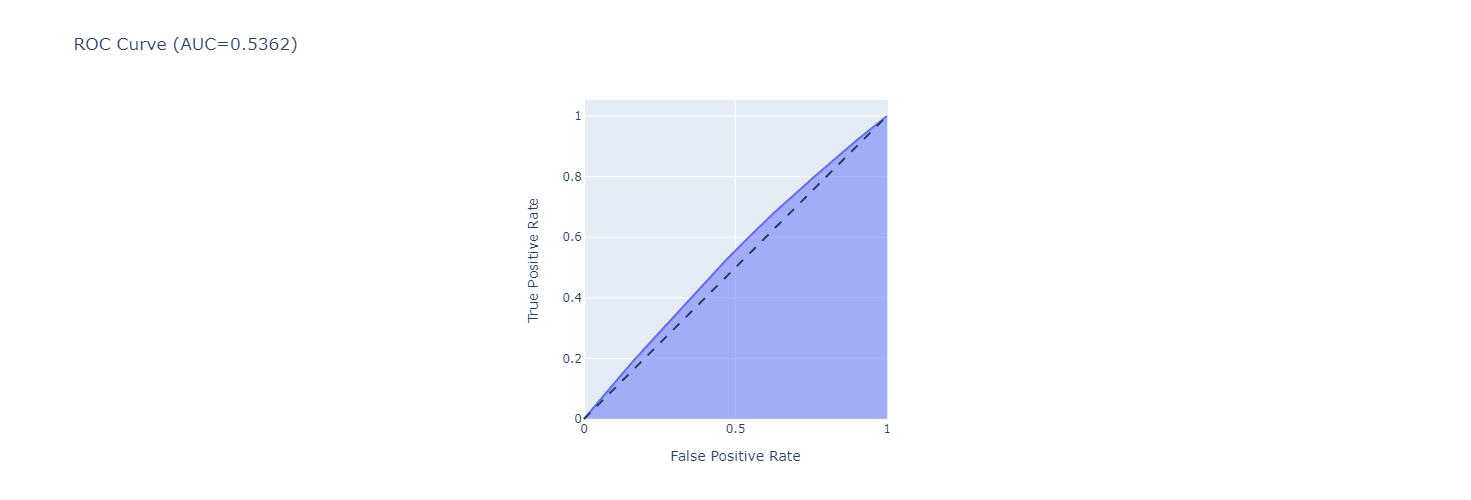

Best Threshold=0.609863


In [23]:
model = keras.models.load_model(f"modelo 0")

# pega predicoes
y_pred = model.predict(test_data)
y_pred = (y_pred+1)/2
# faz ROC curve
import plotly.express as px
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_true, y_pred,)
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

# get the best threshold
J = tpr - fpr
ix = J.argmax()
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))